In [3]:
from google.colab import files
uploaded = files.upload()  # Sélectionnez votre fichier .xlsx

Saving test_features_clean_after_processing.xlsx to test_features_clean_after_processing.xlsx


In [4]:
!pip install openpyxl  # Pour lire les fichiers Excel

In [6]:
# Vérifier les fichiers disponibles
!ls

# Charger les données
import pandas as pd
import io

# Récupérer automatiquement le nom du fichier
file_name = next(iter(uploaded))
df = pd.read_excel(io.BytesIO(uploaded[file_name]), engine='openpyxl')

# Afficher les premières lignes
print(df.head())

# Vérifier les dimensions
print(f"\nDimensions des données : {df.shape}")

# Vérifier les valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())

sample_data  test_features_clean_after_processing.xlsx
                                              sha256  \
0  163ced46c18ef09d8e2f0ee4b16decf74a533f22ba3b59...   
1  485c69ab809ef9401643c3c56567640b88b19285259c1c...   
2  5c851b1a7c507435da84be04b2a62bf0d710d35b4a2838...   
3  fc2900974816fae13b92ff7e8a0339078742336a900ab5...   
4  a42c6d0b8fb3c10a5cc8600400e41af87a7b6c305759f1...   

                                md5 appeared  label avclass  \
0  c747678f13ec94deffeab0c44481a988  2018-11      1   xtrat   
1  de024238e59cccd67eb093071fb4b187  2018-11      1  ramnit   
2  de2d43f0b2c330a32121ad56cad27965  2018-11      1  lethic   
3  3a7a22eb5cf644a71112db457d72396f  2018-11      1  sality   
4  c9bfbed2f1f32edbbc7f63cd1e93789f  2018-11      1  ramnit   

                                           histogram  \
0  [54733, 8020, 5960, 5467, 5567, 4804, 4058, 52...   
1  [181499, 1549, 825, 1002, 1178, 524, 438, 493,...   
2  [9265, 1054, 980, 929, 1573, 820, 877, 1062, 1...   
3  [2

Colonnes disponibles : ['sha256', 'md5', 'appeared', 'label', 'avclass', 'histogram', 'byteentropy', 'strings', 'general', 'header', 'section', 'imports', 'exports', 'datadirectories']

Distribution des labels :
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Valeurs manquantes avant traitement :
sha256                0
md5                   0
appeared              0
avclass            2490
histogram             0
byteentropy           0
strings               0
general               0
header                0
section               0
imports               0
exports              24
datadirectories      46
dtype: int64

Valeurs manquantes après prétraitement :
9952

NaN dans X_train : 0
NaN dans X_test : 0

Dimensions après split - Train: (3980, 14639), Test: (996, 14639)

Modèle entraîné avec succès!

Performance du modèle :
Accuracy: 0.9950
AUC ROC: 0.9976

Matrice de confusion :
[[497   1]
 [  4 494]]

Rapport de classification :
              precision    recall  f1-score   s

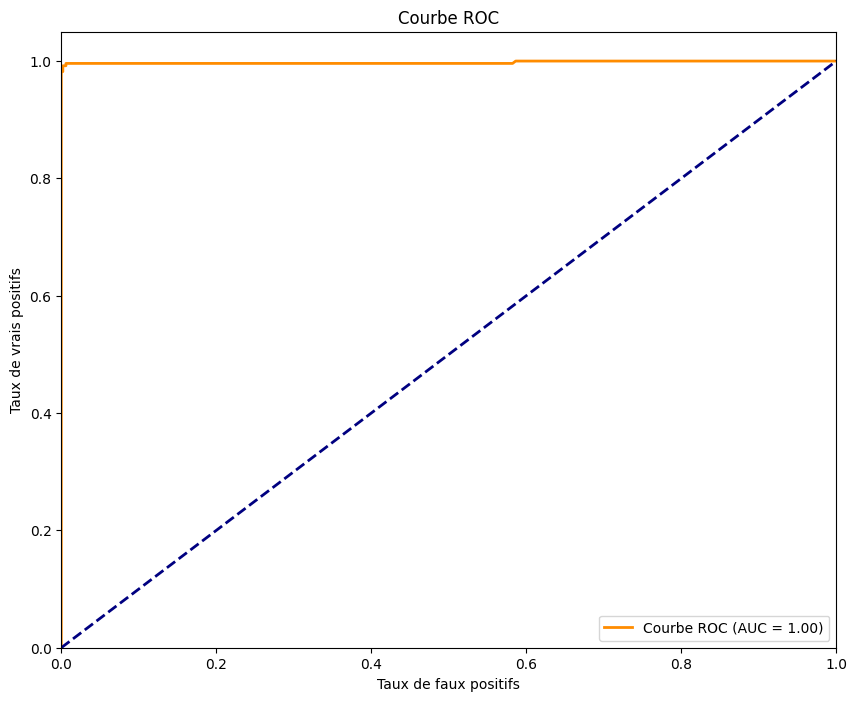

AUC Precision-Recall: 0.9985


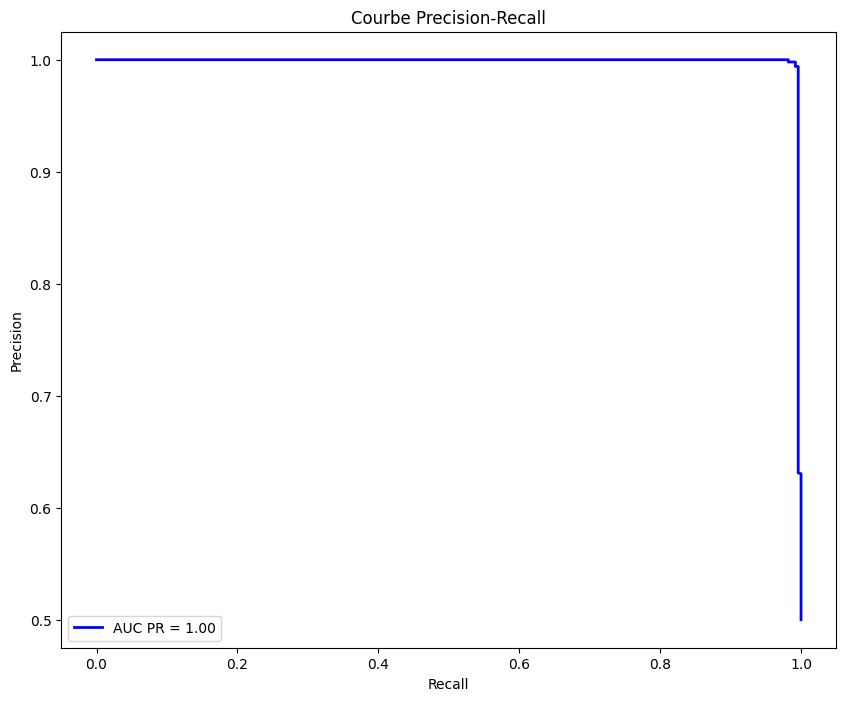

  adding: model_artifacts/ (stored 0%)
  adding: model_artifacts/scaler.pkl (deflated 84%)
  adding: model_artifacts/feature_info.txt (deflated 81%)
  adding: model_artifacts/features_columns.pkl (deflated 81%)
  adding: model_artifacts/modele_regression_logistique.pkl (deflated 61%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
### 4. Prétraitement des données corrigé
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt  # Importation manquante ajoutée ici

# Afficher les noms de colonnes pour identifier la colonne de label
print("Colonnes disponibles :", df.columns.tolist())

# Séparation des features (X) et de la cible (y)
label_col = 'label'
X = df.drop(label_col, axis=1)
y = df[label_col]

# Vérification de la distribution des labels
print("\nDistribution des labels :")
print(y.value_counts(normalize=True))

# Gestion des valeurs manquantes
print("\nValeurs manquantes avant traitement :")
print(X.isnull().sum())

# 1. Supprimer les colonnes non pertinentes (identifiants uniques)
X = X.drop(['sha256', 'md5'], axis=1)

# 2. Traitement spécifique pour chaque colonne
# Colonne 'appeared' - conversion de date
def convert_appeared(date_str):
    try:
        if isinstance(date_str, str):
            # Convertir '2018-11' en datetime
            return datetime.strptime(date_str + '-01', '%Y-%m-%d').timestamp()
        else:
            return np.nan
    except:
        return np.nan

X['appeared'] = X['appeared'].apply(convert_appeared)
# Remplir les valeurs manquantes par la médiane
appeared_median = X['appeared'].median()
X['appeared'] = X['appeared'].fillna(appeared_median)

# Colonnes numériques
numeric_cols = ['exports', 'datadirectories']
for col in numeric_cols:
    # Convertir en numérique en forçant les erreurs à NaN
    X[col] = pd.to_numeric(X[col], errors='coerce')
    # Remplir les NaN par la médiane
    col_median = X[col].median()
    X[col] = X[col].fillna(col_median)

# Colonne 'avclass' (catégorielle)
X['avclass'] = X['avclass'].fillna('missing')  # Remplir les NA par 'missing'

# 3. Traitement des colonnes complexes (histogram, byteentropy, etc.)
complex_cols = ['histogram', 'byteentropy', 'strings', 'general', 'header', 'section', 'imports']
for col in complex_cols:
    # Convertir en chaîne de caractères
    X[col] = X[col].astype(str)
    # Simplifier les valeurs si elles sont trop longues
    X[col] = X[col].apply(lambda x: x[:50] + '...' if len(x) > 50 else x)

# 4. Conversion des variables catégorielles
categorical_cols = ['avclass'] + complex_cols
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 5. Vérification finale des valeurs manquantes
print("\nValeurs manquantes après prétraitement :")
print(X.isnull().sum().sum())  # Devrait être 0

# S'il reste des NaN, les remplacer par 0
X = X.fillna(0)

# Division des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Normalisation des données
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train)
X_test_final = scaler.transform(X_test)

# Vérifier s'il reste des NaN après normalisation
print(f"\nNaN dans X_train : {np.isnan(X_train_final).sum()}")
print(f"NaN dans X_test : {np.isnan(X_test_final).sum()}")

# Si NaN détectés, les remplacer par 0
X_train_final = np.nan_to_num(X_train_final, nan=0.0)
X_test_final = np.nan_to_num(X_test_final, nan=0.0)

print(f"\nDimensions après split - Train: {X_train_final.shape}, Test: {X_test_final.shape}")

### 5. Entraînement du modèle
from sklearn.linear_model import LogisticRegression

# Création du modèle
model = LogisticRegression(
    max_iter=3000,  # Augmenté pour garantir la convergence
    class_weight='balanced',
    random_state=42,
    solver='lbfgs',
    n_jobs=-1  # Utiliser tous les cœurs pour accélérer l'entraînement
)

# Entraînement
model.fit(X_train_final, y_train)
print("\nModèle entraîné avec succès!")

### 6. Évaluation du modèle
from sklearn.metrics import (accuracy_score, confusion_matrix,
                            classification_report, roc_auc_score,
                            precision_recall_curve, auc, roc_curve)

# Prédictions
y_pred = model.predict(X_test_final)
y_proba = model.predict_proba(X_test_final)[:, 1]  # Probabilités pour la classe 1

# Métriques d'évaluation
print("\nPerformance du modèle :")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC ROC: {roc_auc_score(y_test, y_proba):.4f}")

# Rapport détaillé
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred))

print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

# Courbe Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"AUC Precision-Recall: {pr_auc:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'AUC PR = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall')
plt.legend(loc='best')
plt.show()

### 7. Sauvegarde du modèle
import joblib
import os

# Créer un dossier pour sauvegarder les artefacts
os.makedirs('model_artifacts', exist_ok=True)

# Sauvegarder le modèle et le scaler
joblib.dump(model, 'model_artifacts/modele_regression_logistique.pkl')
joblib.dump(scaler, 'model_artifacts/scaler.pkl')
joblib.dump(list(X.columns), 'model_artifacts/features_columns.pkl')

# Sauvegarder les informations sur les colonnes
with open('model_artifacts/feature_info.txt', 'w') as f:
    f.write("Colonnes utilisées pour l'entraînement:\n")
    f.write("\n".join(X.columns))

    f.write("\n\nTypes de données:\n")
    f.write(str(X.dtypes))

# Compresser le dossier
!zip -r model_artifacts.zip model_artifacts

# Télécharger les fichiers
from google.colab import files
files.download('model_artifacts.zip')